# Plotting

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import json
import matplotlib.pyplot as plt
from ast import literal_eval as make_tuple
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [2]:
bus_df = pd.read_csv('./Data/CTA_-_Ridership_-_Avg._Weekday_Bus_Stop_Boardings_in_October_2012.csv')

In [3]:
bus_df.head()

,stop_id,on_street,cross_street,routes,boardings,alightings,month_beginning,daytype,location
0,1,JACKSON,AUSTIN,126,183.4,150.0,10/01/2012,Weekday,"(41.87632184, -87.77410482)"
1,2,JACKSON,MAYFIELD (EXTENDED),126,5.3,0.2,10/01/2012,Weekday,"(41.87706679, -87.77131794)"
2,3,JACKSON,MENARD,126,8.3,0.7,10/01/2012,Weekday,"(41.87695725, -87.76975039)"
3,4,JACKSON,5700 WEST,126,17.9,3.0,10/01/2012,Weekday,"(41.87702418, -87.76745055)"
4,6,JACKSON,LOTUS,126,74.0,11.2,10/01/2012,Weekday,"(41.876513, -87.761446)"


In [4]:
bus_df.dropna(axis=0,inplace=True)

In [5]:
bus_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11591 entries, 0 to 11592
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   stop_id          11591 non-null  int64  
 1   on_street        11591 non-null  object 
 2   cross_street     11591 non-null  object 
 3   routes           11591 non-null  object 
 4   boardings        11591 non-null  float64
 5   alightings       11591 non-null  float64
 6   month_beginning  11591 non-null  object 
 7   daytype          11591 non-null  object 
 8   location         11591 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 905.5+ KB


In [6]:
bus_df.drop(columns=['month_beginning','daytype'],inplace=True)

In [7]:
bus_df['location'] = bus_df['location'].apply(make_tuple)

In [8]:
def get_lat(i):
    return i[0]
def get_long(i):
    return i[1]

def safe_log(x):
    # return 0 when log(0)
    if x <= 0:
        return 0
    return np.log(x)

In [9]:
bus_df['lat'] = bus_df['location'].apply(get_lat)
bus_df['long'] = bus_df['location'].apply(get_long)
bus_df.drop(columns = 'location',inplace = True)

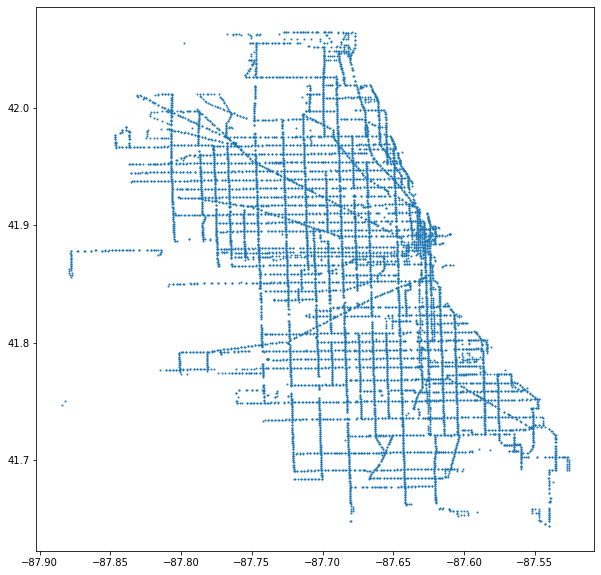

In [10]:
plt.figure(figsize=(10, 10))
plt.scatter(bus_df.long, bus_df.lat,s=1);

In [11]:
bus_df['alightings_log'] = bus_df['alightings'].apply(safe_log)
bus_df['boardings_log'] = bus_df['boardings'].apply(safe_log)

In [12]:
bus_df['total_ridership_log'] = bus_df['alightings_log'] + bus_df['boardings_log']
bus_df['total_ridership'] = bus_df['alightings'] + bus_df['boardings']

In [13]:
X = bus_df[['long','lat','total_ridership_log']]
#X = bus_df[['long','lat','total_ridership']]
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# KMEAN cluster base on location and ridership

In [14]:
# GridSearch to find the best number of cluster
scores = []
for k in range(2, 31):
    cl = KMeans(n_clusters=k)
    cl.fit(X_sc)
    inertia = cl.inertia_
    sil = silhouette_score(X_sc, cl.labels_)
    scores.append([k, inertia, sil])
    
score_df = pd.DataFrame(scores)
score_df.columns = ['k', 'inertia', 'silhouette']

Text(0.5, 1.0, 'Silhouette Score over k')

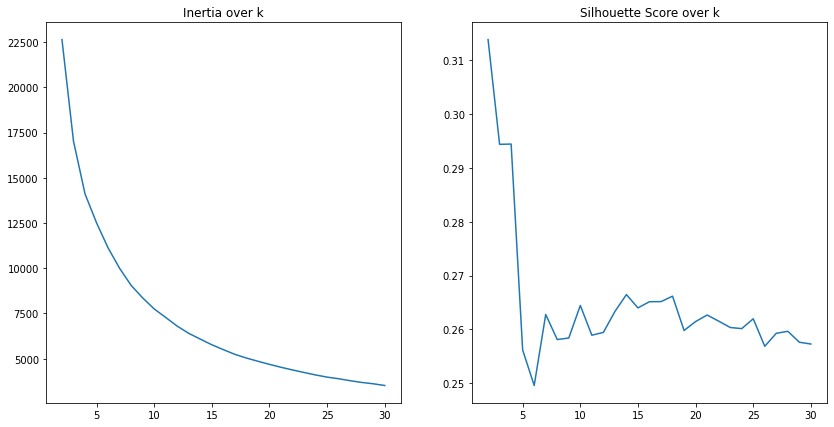

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].plot(score_df.k, score_df.inertia)
axes[0].set_title('Inertia over k')
axes[1].plot(score_df.k, score_df.silhouette);
axes[1].set_title('Silhouette Score over k')

In [16]:
km = KMeans(n_clusters=4)
km.fit(X_sc)
# Scaled X gives best results
bus_df['cluster'] = km.labels_

# Plot

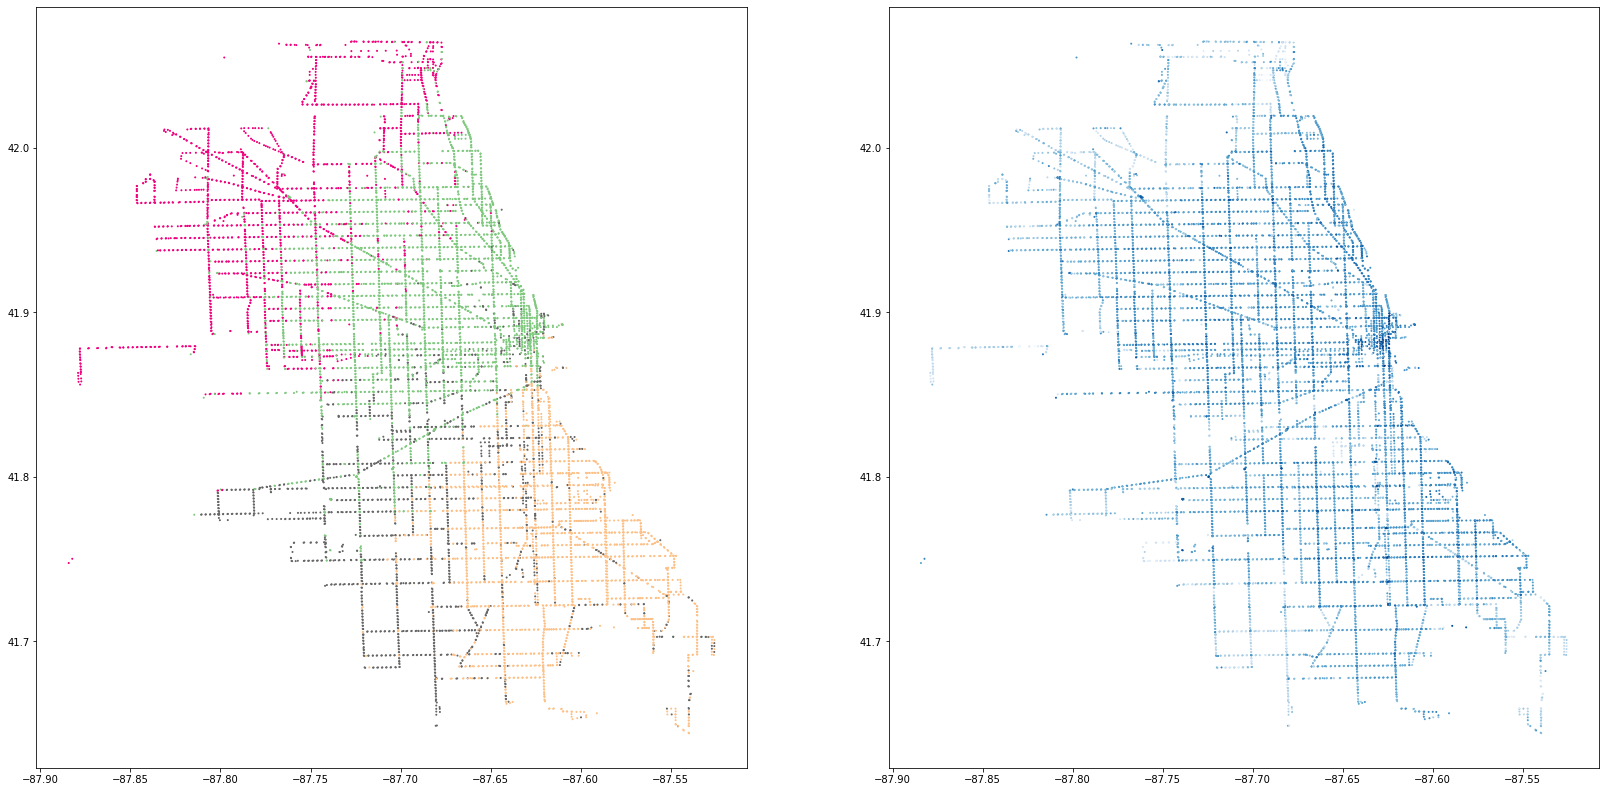

In [17]:
plt.figure(figsize=(28,14))
plt.subplot(1,2,1)
plt.scatter(bus_df.long, bus_df.lat,s=1,c = bus_df['cluster'],cmap="Accent");
plt.subplot(1,2,2)
plt.scatter(bus_df.long, bus_df.lat,s=1,c = bus_df['total_ridership_log'],cmap="Blues");

# KMEAN cluster base on only ridership 

In [18]:
X_rider = bus_df[['total_ridership_log']]
km = KMeans(n_clusters=4)
km.fit(X_rider)
# Scaled X gives best results
bus_df['cluster_rider'] = km.labels_

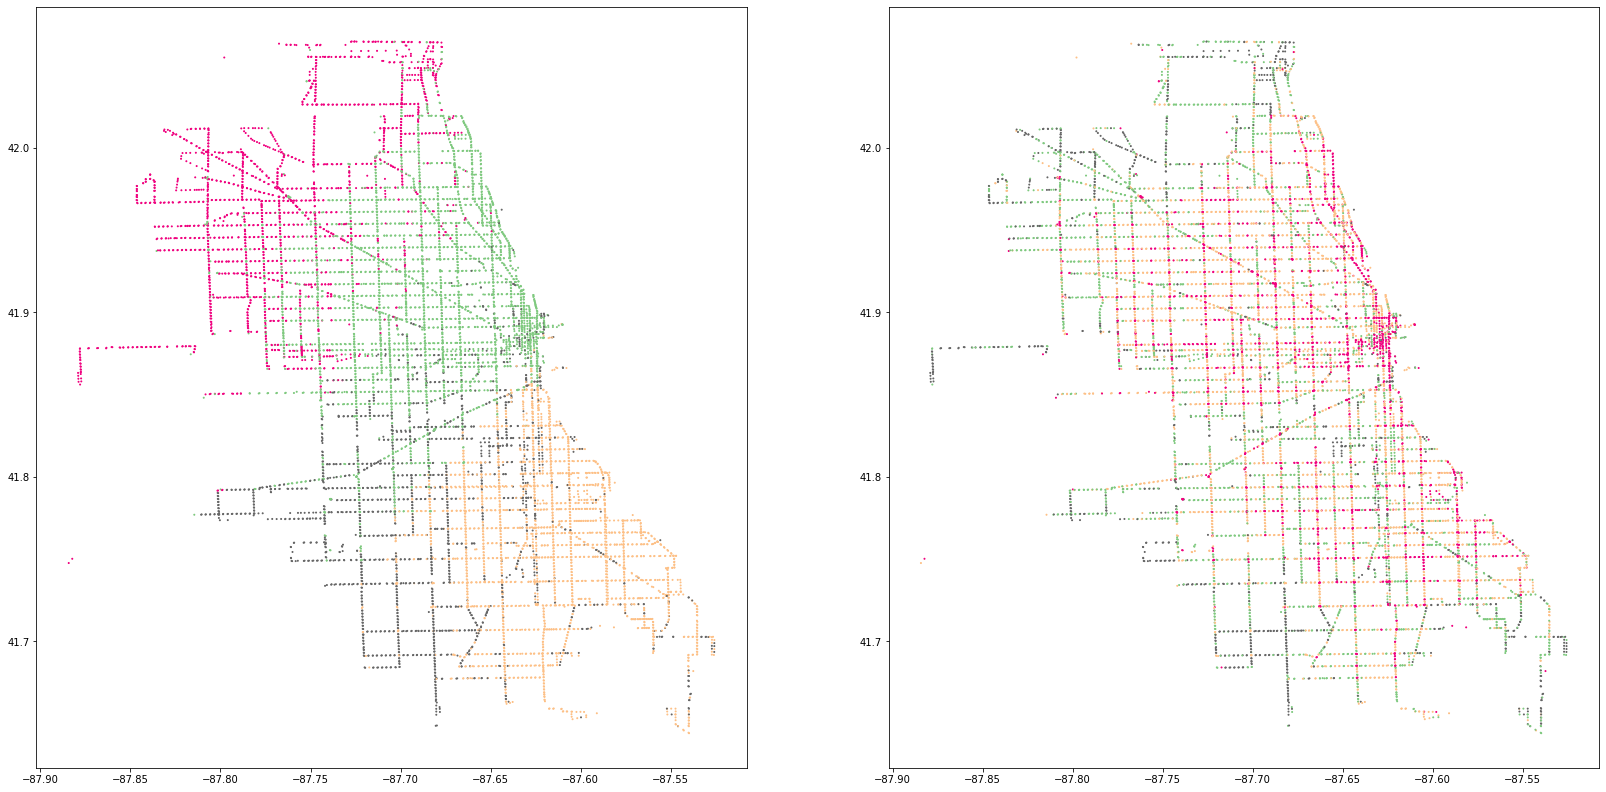

In [19]:
plt.figure(figsize=(28,14))
plt.subplot(1,2,1)
plt.scatter(bus_df.long, bus_df.lat,s=1,c = bus_df['cluster'],cmap="Accent");
plt.subplot(1,2,2)
plt.scatter(bus_df.long, bus_df.lat,s=1,c = bus_df['cluster_rider'],cmap="Accent");

In [20]:
# Check the average ridership by cluster
bus_df.groupby(['cluster']).mean()['total_ridership']

cluster
0    302.726881
1    214.779591
2     40.703929
3     27.049904
Name: total_ridership, dtype: float64